In [1]:
import os
import sys

sys.path.append(os.environ['RENNET_ROOT'])
data_root = os.path.join(os.environ['RENNET_X_ROOT'], 'data')

print('DATA ROOT:', data_root)

DATA ROOT: /Users/abdullah/Delve/iais/rennet-x/data


In [203]:
import numpy as np
import glob

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

import matplotlib.gridspec as g

plt.style.use('seaborn-muted')
plt.rcParams.update({'font.size': 15, 'axes.titlesize': 'large', 'axes.labelsize': 'large', 
                     'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium'})
COLORS = (
    'grey',
    'yellowgreen',
    'lightcoral',
    'lightskyblue',
    'sandybrown',
    'yellowgreen',
    'cornflowerblue',
    'darkorange',
    'orchid',
)
from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list('DT', COLORS[:3], N=3)

from collections import defaultdict, Counter

In [124]:
import rennet.utils.plotting_utils as pu
import rennet.datasets.fisher as fe
import rennet.utils.np_utils as nu

In [46]:
working_data_root = os.path.join(data_root, 'working',
                                 'fisher', 'fe_03_p1m',
                                 'raw', 'labels', )
#                                  'wav-8k-mono', '**', 'labels', )
flabels = glob.glob(os.path.join(working_data_root, 'data',
                                 '**', '*.txt', ), recursive=True)
fcalldata = glob.glob(os.path.join(working_data_root, 
                                   '*calldata.tbl', ))[0]

print('# LABEL FILES :', len(flabels))
print('CALLDATA AT:\n', fcalldata)

# LABEL FILES : 5850
CALLDATA AT:
 /Users/abdullah/Delve/iais/rennet-x/data/working/fisher/fe_03_p1m/raw/labels/fe_03_p1_calldata.tbl


In [47]:
allcalldata = fe.AllCallData.from_file(fcalldata)
print(len(allcalldata.allcalldata))

5850


In [48]:
%%time
annots = [fe.Annotations.from_file(f, allcalldata=allcalldata)
          for f in flabels]

CPU times: user 17 s, sys: 1.05 s, total: 18.1 s
Wall time: 20.4 s


In [49]:
%%time
acts = [fe.ActiveSpeakers.from_annotations(a, warn_duplicates=False)
          for a in annots]

CPU times: user 6.77 s, sys: 111 ms, total: 6.88 s
Wall time: 7 s


In [50]:
active_speaker_segments = defaultdict(list)
for act in acts:
    with act.samplerate_as(100):
        for se, l in zip(np.diff(act.starts_ends, axis=1), act.labels.sum(axis=1)):
            active_speaker_segments[l].append(se)

In [51]:
totsegs = sum(len(v) for v in active_speaker_segments.values())
totlens = sum(sum(v) for v in active_speaker_segments.values())
print(totsegs, totlens)

2215723 [  3.45707167e+08]


In [52]:
for k, v in active_speaker_segments.items():
    print(k, len(v), len(v)/totsegs, sum(v), sum(v)/totlens)

0 451849 0.20392846939802495 [ 23737828.1] [ 0.06866455]
1 1128395 0.5092671782528773 [  2.75204976e+08] [ 0.79606384]
2 635479 0.2868043523490978 [ 46764363.] [ 0.1352716]


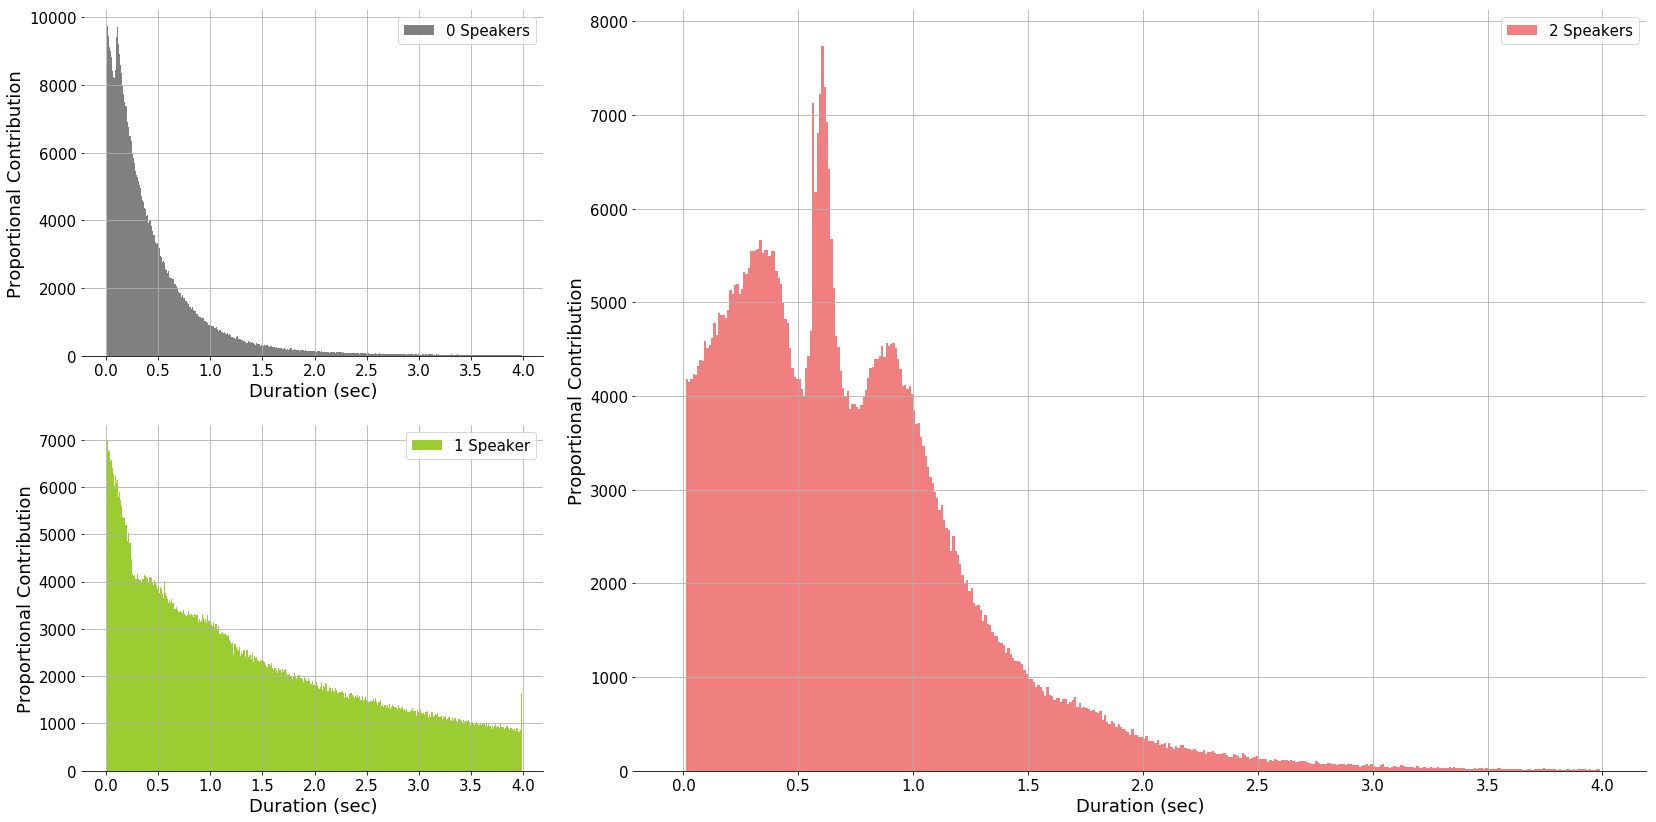

In [66]:
# fig, axi = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
plt.figure(figsize=(28, 14))
gs = g.GridSpec(2, 3)

axi = [plt.subplot(gg) for gg in [gs[0, 0], gs[1, 0], gs[:, 1:]]]
for d in range(3):
    ax = axi[d]
    x = np.array(active_speaker_segments[d])
    ax.hist(x, bins=400, 
            color=COLORS[d],# alpha=0.5,
            range=(-1, 399),
            label="{} Speaker{}".format(d, "s" if d != 1 else ""),
#             normed=True,
#             histtype='stepfilled',
            linewidth=0,
#             weights=x/x.sum()
           )
    
    ax.legend(loc='upper right')
#     ax.get_yaxis().set_visible(False)
    for s in ['top', 'right', 'left']:
        ax.spines[s].set_visible(False)

    ax.grid()
    ax.set_xticklabels([t / 100 for t in ax.get_xticks()])
    ax.set_xlabel('Duration (sec)')
    ax.set_ylabel('Proportional Contribution')

In [59]:
np.median(active_speaker_segments[2])

63.0

In [64]:
plt.hist?

In [44]:
np.array(active_speaker_segments[2]).shape

(66469, 1)

In [92]:
gender_segments = defaultdict(list)
gender_calls = defaultdict(list)
for act in acts:
    with act.samplerate_as(100):
        genders = [s.gender for s in act.calldata.channelspeakers]
        gender_calls[''.join(sorted(genders))].extend(
            np.diff(act.starts_ends[act.labels.sum(axis=1) > 0], axis=1))
        for se, l in zip(np.diff(act.starts_ends, axis=1), act.labels):
            g = ''.join(sorted(gg if i == 1 else '' for gg, i in zip(genders, l)))
            gender_segments[g].append(se)
            gender_segments[len(g)].append(se)

In [93]:
list(gender_segments.keys()), list(gender_calls.keys())

(['', 1, 2, 'f', 0, 'mm', 'fm', 'ff', 'm'], ['fm', 'mm', 'ff'])

In [94]:
totsegs = [len(gender_segments[i]) for i in range(3)]
totsecs = [sum(gender_segments[i]) for i in range(3)]

In [95]:
totsegs, totsecs

([451849, 1128395, 635479],
 [array([ 23737828.1]), array([  2.75204976e+08]), array([ 46764363.])])

In [96]:
for k, v in gender_segments.items():
    if isinstance(k, str):
        print(k, len(v), len(v)/totsegs[len(k)], sum(v), sum(v)/totsecs[len(k)])

 451849 1.0 [ 23737828.1] [ 1.]
f 657160 0.582384714572468 [152690560] [ 0.55482485]
mm 164455 0.25878903944898257 [ 12656545.] [ 0.27064509]
fm 200972 0.3162527793994766 [14436451] [ 0.30870625]
ff 270052 0.4249581811515408 [19671367] [ 0.42064867]
m 471235 0.417615285427532 [  1.22514416e+08] [ 0.44517515]


In [97]:
overall_totcals = sum(len(v) for v in gender_calls.values())
overall_totsecs = sum(sum(v) for v in gender_calls.values())

In [98]:
overall_totcals, overall_totsecs

(1763874, array([  3.21969339e+08]))

In [99]:
for k, v in gender_calls.items():
    print(k, len(v), len(v)/overall_totcals, sum(v), sum(v)/overall_totsecs)

fm 573051 0.32488204939808624 [104063470] [ 0.32320925]
mm 446861 0.2533406581195709 [ 88741340.90000001] [ 0.27562047]
ff 743962 0.42177729248234286 [129164528] [ 0.40117027]


In [101]:
for k, v in gender_segments.items():
    if isinstance(k, str) and len(k) > 1:
        print(k, len(v), len(v)/len(gender_calls[k]), sum(v), sum(v)/sum(gender_calls[k]))

mm 164455 0.3680227184739774 [ 12656545.] [ 0.14262287]
fm 200972 0.35070526009028863 [14436451] [ 0.13872737]
ff 270052 0.36299165817608964 [19671367] [ 0.15229698]


In [105]:
allspeakers = [c.channelspeakers for c in allcalldata]
a, b = zip(*allspeakers)
allspeakers = a + b
len(allspeakers)

11700

In [115]:
uallspeakers = {(s.pin, s.gender, s.dialect) for s in allspeakers}
len(uallspeakers)

7322

In [121]:
len({s.pin for s in allspeakers})

7066

In [119]:
max(allspeakers, key=lambda s: s.pin), min(allspeakers, key=lambda s: s.pin)

(fisher.Speaker(pin='99997', gender='f', dialect='a'),
 fisher.Speaker(pin='10010', gender='m', dialect='a'))

In [122]:
len(acts)

5850

In [130]:
l = nu.to_categorical(acts[1].labels.sum(axis=1), nclasses=3).astype(bool)
se = np.diff(acts[1].starts_ends, axis=1)

sums = (se[l[..., 0]].sum(), se[l[..., 1]].sum(), se[l[..., 2]].sum())
sums = np.array(sums)
print(sums, sums/sums.sum())

[19319 50947  1643] [ 0.268659    0.70849268  0.02284832]


In [132]:
len(acts)

5850

In [143]:
val = acts[:99]
trn = acts[99:4099]
tst = acts[4099:]

len(val), len(trn), len(tst)

(99, 4000, 1751)

In [144]:
def actspksegs(acts):
    active_speaker_segments = defaultdict(list)
    for act in acts:
        with act.samplerate_as(100):
            for se, l in zip(np.diff(act.starts_ends, axis=1), act.labels.sum(axis=1)):
                active_speaker_segments[l].append(se)
                
    return active_speaker_segments

In [145]:
def gendersegs(acts):
    gender_segments = defaultdict(list)
    gender_calls = defaultdict(list)
    for act in acts:
        with act.samplerate_as(100):
            genders = [s.gender for s in act.calldata.channelspeakers]
            gender_calls[''.join(sorted(genders))].extend(
                np.diff(act.starts_ends[act.labels.sum(axis=1) > 0], axis=1))
            for se, l in zip(np.diff(act.starts_ends, axis=1), act.labels):
                g = ''.join(sorted(gg if i == 1 else '' for gg, i in zip(genders, l)))
                gender_segments[g].append(se)
                gender_segments[len(g)].append(se)
    return gender_segments, gender_calls

In [146]:
val_actspksegs = actspksegs(val)
val_gendersegs = gendersegs(val)

In [147]:
trn_actspksegs = actspksegs(trn)
trn_gendersegs = gendersegs(trn)


In [148]:
tst_actspksegs = actspksegs(tst)
tst_gendersegs = gendersegs(tst)

In [151]:
val_totsegs = sum(len(v) for v in val_actspksegs.values())
val_totlens = sum(sum(v) for v in val_actspksegs.values())
print(val_totsegs, val_totlens)


47485 [6015059]


In [153]:
trn_totsegs = sum(len(v) for v in trn_actspksegs.values())
trn_totlens = sum(sum(v) for v in trn_actspksegs.values())
print(trn_totsegs, trn_totlens)

1550783 [  2.35026016e+08]


In [154]:
tst_totsegs = sum(len(v) for v in tst_actspksegs.values())
tst_totlens = sum(sum(v) for v in tst_actspksegs.values())
print(tst_totsegs, tst_totlens)

617455 [104666092]


In [156]:
totsegs = sum((val_totsegs, trn_totsegs, tst_totsegs))

print([s/totsegs for s in (val_totsegs, trn_totsegs, tst_totsegs)])

[0.021430927963468356, 0.699899310518508, 0.2786697615180237]


In [157]:
totlens = sum((val_totlens, trn_totlens, tst_totlens))

print([s/totlens for s in (val_totlens, trn_totlens, tst_totlens)])

[array([ 0.01739929]), array([ 0.67984132]), array([ 0.30275939])]


In [160]:
def hms(s):
    m, sec = divmod(s, 60)
    h, m = divmod(m, 60)
    
    return h, m, sec

In [162]:
list(map(hms, (val_totlens/100, trn_totlens/100, tst_totlens/100, totlens/100)))

[(array([ 16.]), array([ 42.]), array([ 30.59])),
 (array([ 652.]), array([ 51.]), array([ 0.16])),
 (array([ 290.]), array([ 44.]), array([ 20.92])),
 (array([ 960.]), array([ 17.]), array([ 51.67]))]

In [163]:
[l/360000 for l in (val_totlens, trn_totlens, tst_totlens, totlens)]

[array([ 16.70849722]),
 array([ 652.85004444]),
 array([ 290.73914444]),
 array([ 960.29768611])]

In [164]:
fe.chosen_val_callids

['00007', '00013', '00028', '00062', '00065', '00069', '00086']

In [165]:
uval = [val[int(i)-1] for i in fe.chosen_val_callids]
print([uv.callid for uv in uval])
utrn = trn[:1200]
utst = tst[-551:]

len(uval), len(utrn), len(utst)

['00007', '00013', '00028', '00062', '00065', '00069', '00086']


(7, 1200, 551)

In [166]:
uval_actspksegs = actspksegs(uval)
uval_gendersegs = gendersegs(uval)

utrn_actspksegs = actspksegs(utrn)
utrn_gendersegs = gendersegs(utrn)

utst_actspksegs = actspksegs(utst)
utst_gendersegs = gendersegs(utst)

In [167]:
uval_totsegs = sum(len(v) for v in uval_actspksegs.values())
uval_totlens = sum(sum(v) for v in uval_actspksegs.values())
print(uval_totsegs, uval_totlens)

utrn_totsegs = sum(len(v) for v in utrn_actspksegs.values())
utrn_totlens = sum(sum(v) for v in utrn_actspksegs.values())
print(utrn_totsegs, utrn_totlens)

utst_totsegs = sum(len(v) for v in utst_actspksegs.values())
utst_totlens = sum(sum(v) for v in utst_actspksegs.values())
print(utst_totsegs, utst_totlens)

3218 [481950]
498805 [ 67760252.]
186536 [32933787]


In [168]:
utotsegs = sum((uval_totsegs, utrn_totsegs, utst_totsegs))

print([s/utotsegs for s in (uval_totsegs, utrn_totsegs, utst_totsegs)])


[0.004673528339619408, 0.7244186772665814, 0.27090779439379925]


In [169]:
utotlens = sum((uval_totlens, utrn_totlens, utst_totlens))

print([s/utotlens for s in (uval_totlens, utrn_totlens, utst_totlens)])


[array([ 0.00476348]), array([ 0.66972661]), array([ 0.32550991])]


In [170]:
list(map(hms, (uval_totlens/100, utrn_totlens/100, utst_totlens/100, utotlens/100)))


[(array([ 1.]), array([ 20.]), array([ 19.5])),
 (array([ 188.]), array([ 13.]), array([ 22.52])),
 (array([ 91.]), array([ 28.]), array([ 57.87])),
 (array([ 281.]), array([ 2.]), array([ 39.89]))]

In [171]:
[l/360000 for l in (uval_totlens, utrn_totlens, utst_totlens, utotlens)]


[array([ 1.33875]),
 array([ 188.22292222]),
 array([ 91.48274167]),
 array([ 281.04441389])]

In [172]:
def actspk_ratios(active_speaker_segments, totsegs, totlens):
    for k, v in active_speaker_segments.items():
        print(k, len(v), len(v)/totsegs, sum(v), sum(v)/totlens)

In [176]:
actspk_ratios(val_actspksegs, val_totsegs, val_totlens)
print()
actspk_ratios(uval_actspksegs, uval_totsegs, uval_totlens)

0 15264 0.32144887859323995 [976843] [ 0.16239957]
1 23891 0.5031273033589555 [4553266] [ 0.75697778]
2 8330 0.17542381804780457 [484950] [ 0.08062265]

0 496 0.15413300186451212 [30136] [ 0.06252931]
1 1628 0.5059042883778745 [374795] [ 0.77766366]
2 1094 0.33996270975761345 [77019] [ 0.15980703]


In [177]:
actspk_ratios(trn_actspksegs, trn_totsegs, trn_totlens)
print()
actspk_ratios(utrn_actspksegs, utrn_totsegs, utrn_totlens)

0 327149 0.21095730350410083 [ 17673689.1] [ 0.07519886]
1 787566 0.5078505503348953 [  1.85763994e+08] [ 0.79039758]
2 436068 0.28119214616100385 [ 31588333.] [ 0.13440356]

0 145577 0.29185152514509677 [ 9660658.1] [ 0.14257117]
1 251602 0.5044095387977265 [ 51524334.9] [ 0.76039172]
2 101626 0.20373893605717666 [ 6575259.] [ 0.09703711]


In [178]:
actspk_ratios(tst_actspksegs, tst_totsegs, tst_totlens)
print()
actspk_ratios(utst_actspksegs, utst_totsegs, utst_totlens)

0 109436 0.17723720756978242 [5087296] [ 0.04860501]
1 316938 0.5132973253111562 [84887716] [ 0.81103359]
2 191081 0.3094654671190613 [14691080] [ 0.14036141]

0 32613 0.17483488441909337 [1584560] [ 0.04811351]
1 96215 0.5157985589912939 [26741848] [ 0.81198825]
2 57708 0.3093665565896127 [4607379] [ 0.13989824]


In [198]:
def plot_segs(active_speaker_segments, weighted=False):
    # fig, axi = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.figure(figsize=(28, 14))
    gs = g.GridSpec(2, 3)

    axi = [plt.subplot(gg) for gg in [gs[0, 0], gs[1, 0], gs[:, 1:]]]
    for d in range(3):
        ax = axi[d]
        x = np.array(active_speaker_segments[d])
        ax.hist(x, bins=400, 
                color=COLORS[d],# alpha=0.5,
                range=(-1, 399),
                label="{} Speaker{}".format(d, "s" if d != 1 else ""),
                normed=True,
    #             histtype='stepfilled',
                linewidth=0,
                weights=x/x.sum() if weighted else None,
               )

        ax.legend(loc='upper right')
    #     ax.get_yaxis().set_visible(False)
        for s in ['top', 'right', 'left']:
            ax.spines[s].set_visible(False)

        ax.grid()
        ax.set_xticklabels([t / 100 for t in ax.get_xticks()])
        ax.set_xlabel('Duration (sec)')
        ax.set_ylabel('Proportional contribution')


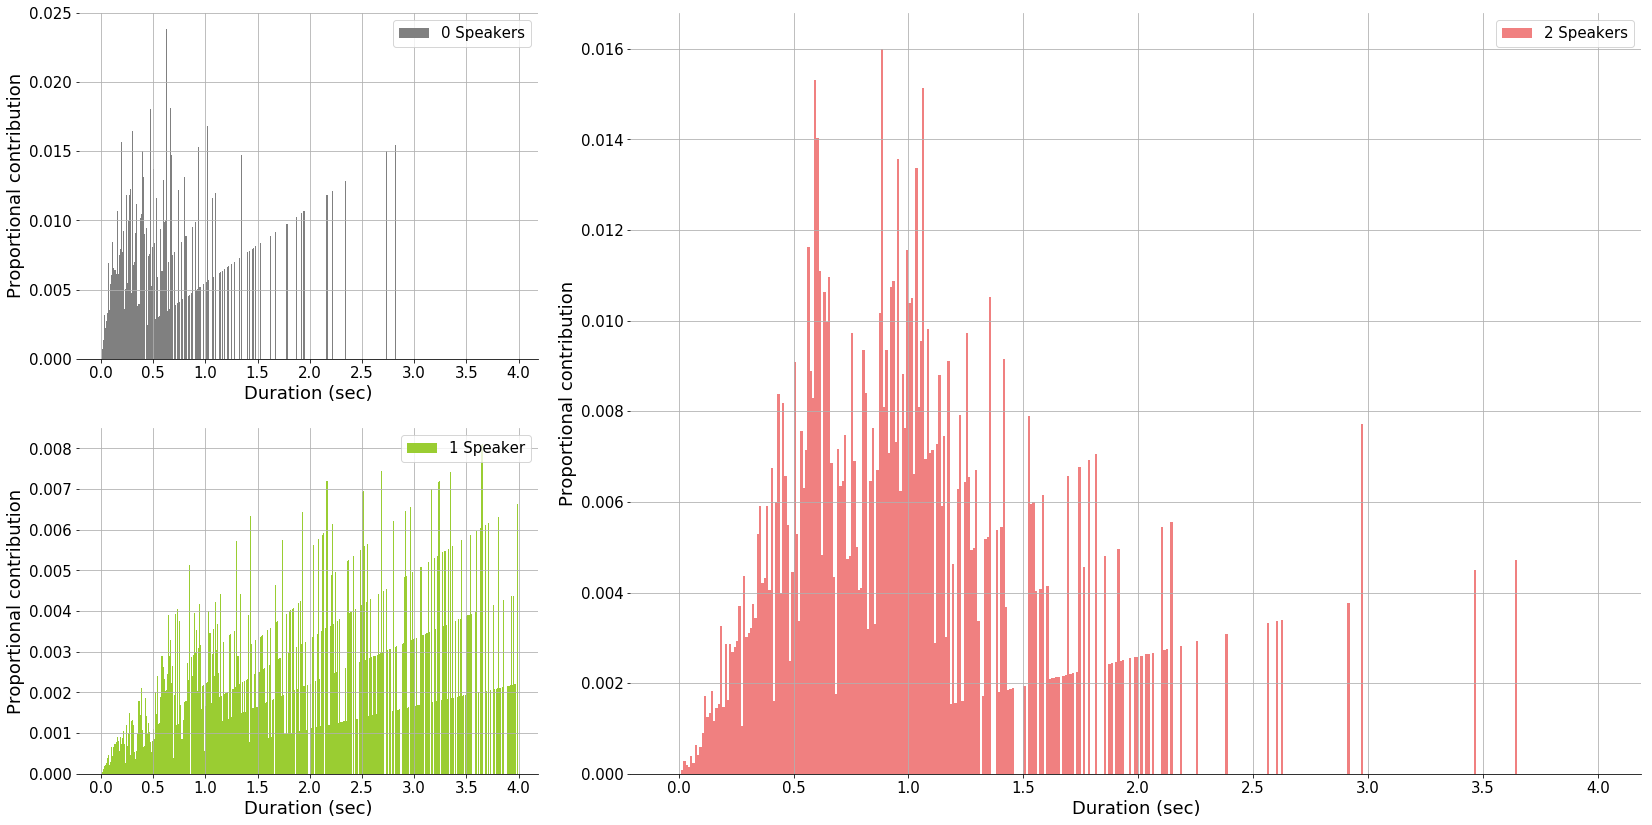

In [199]:
# plot_segs(uval_actspksegs)
plot_segs(uval_actspksegs, weighted=True)

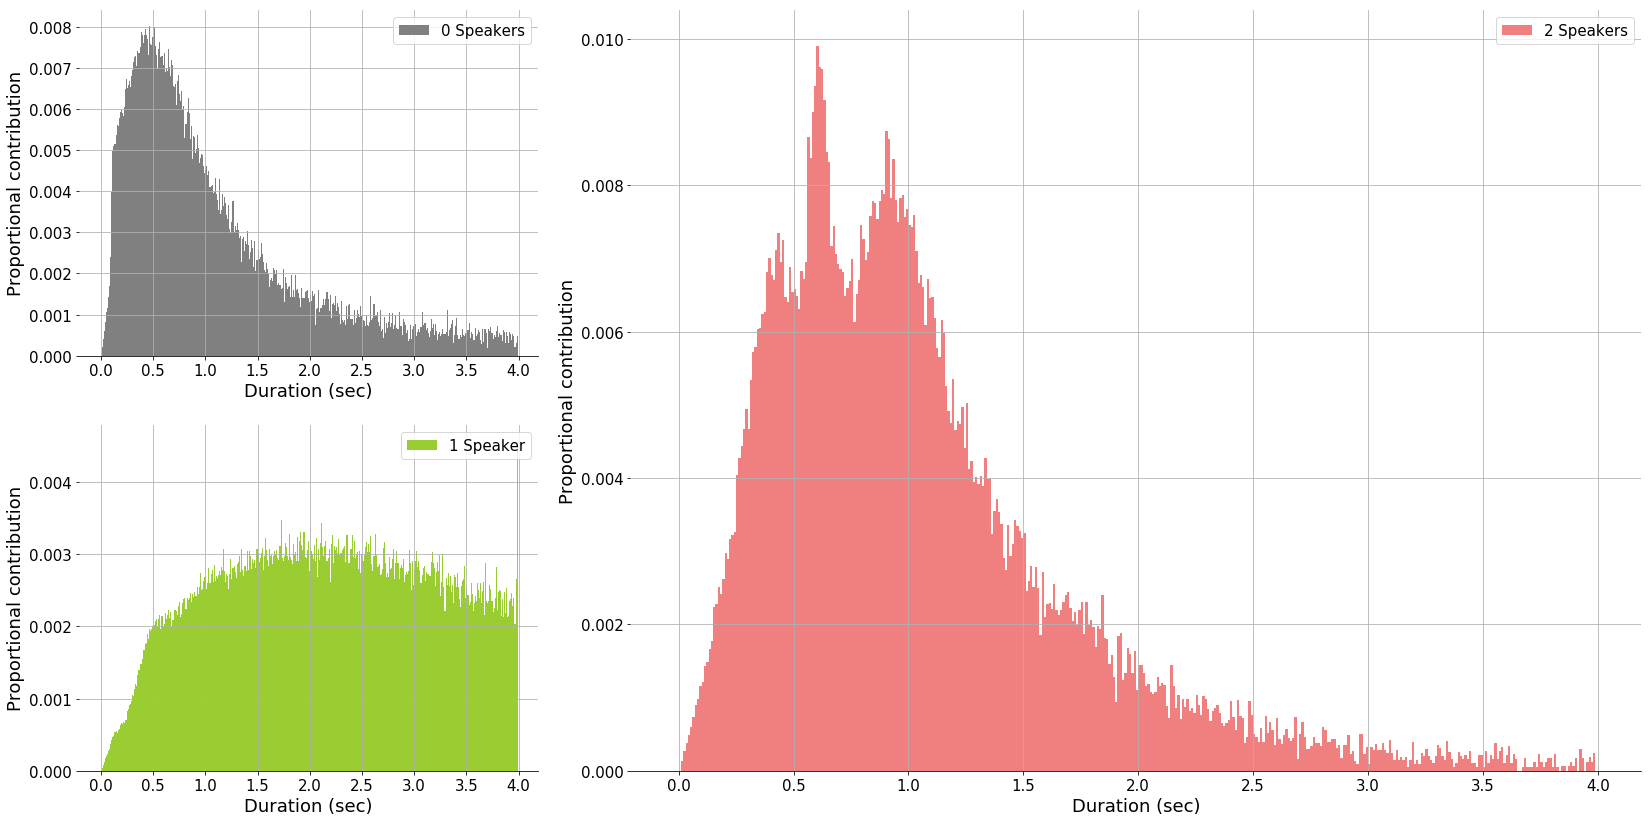

In [200]:
# plot_segs(utrn_actspksegs)
plot_segs(utrn_actspksegs, weighted=True)

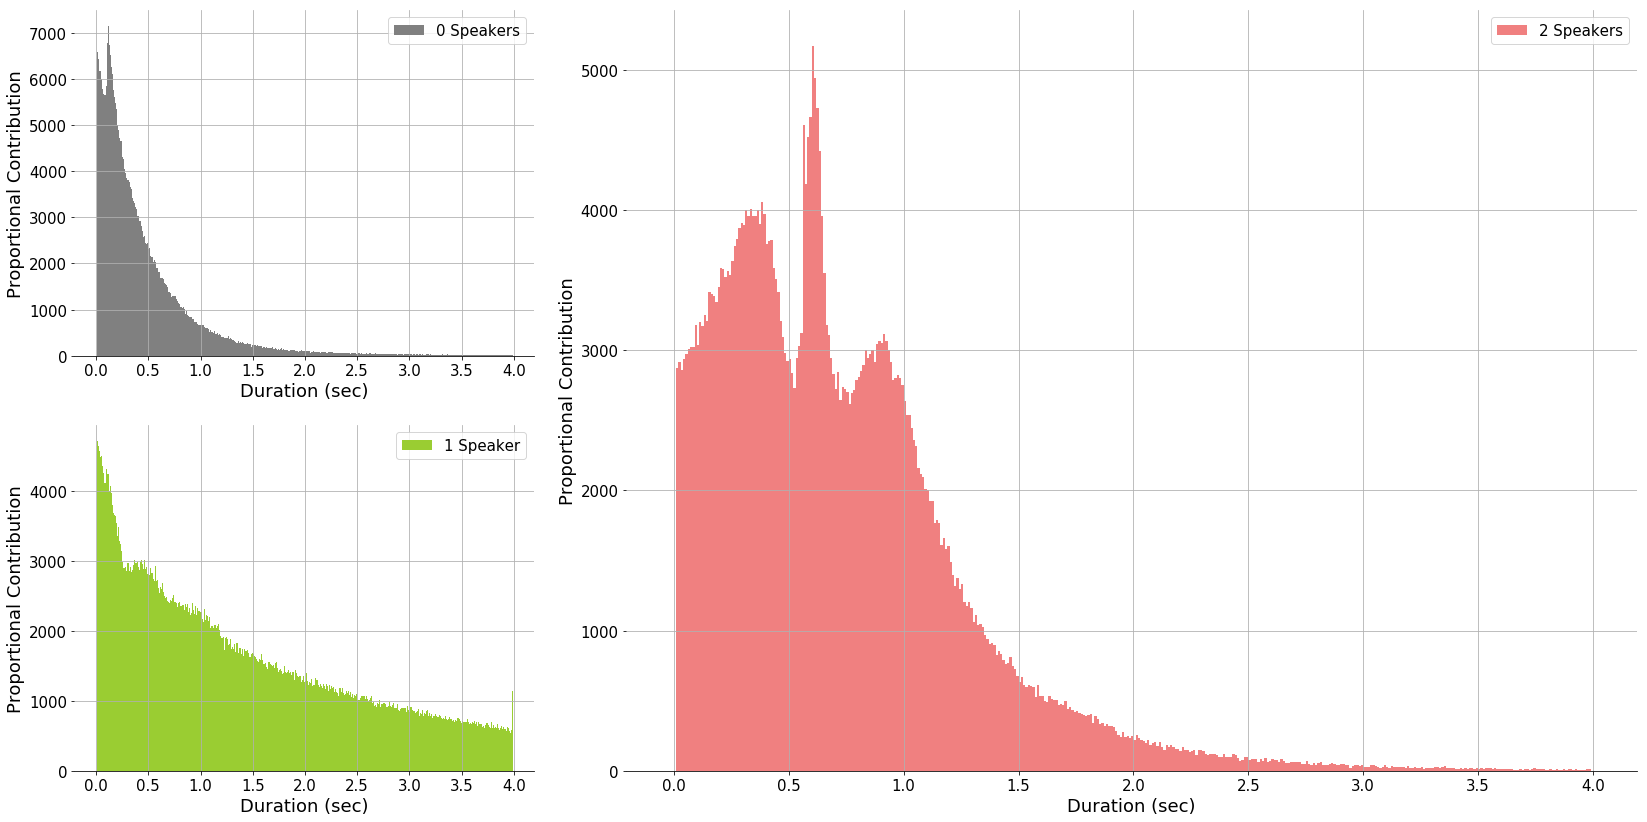

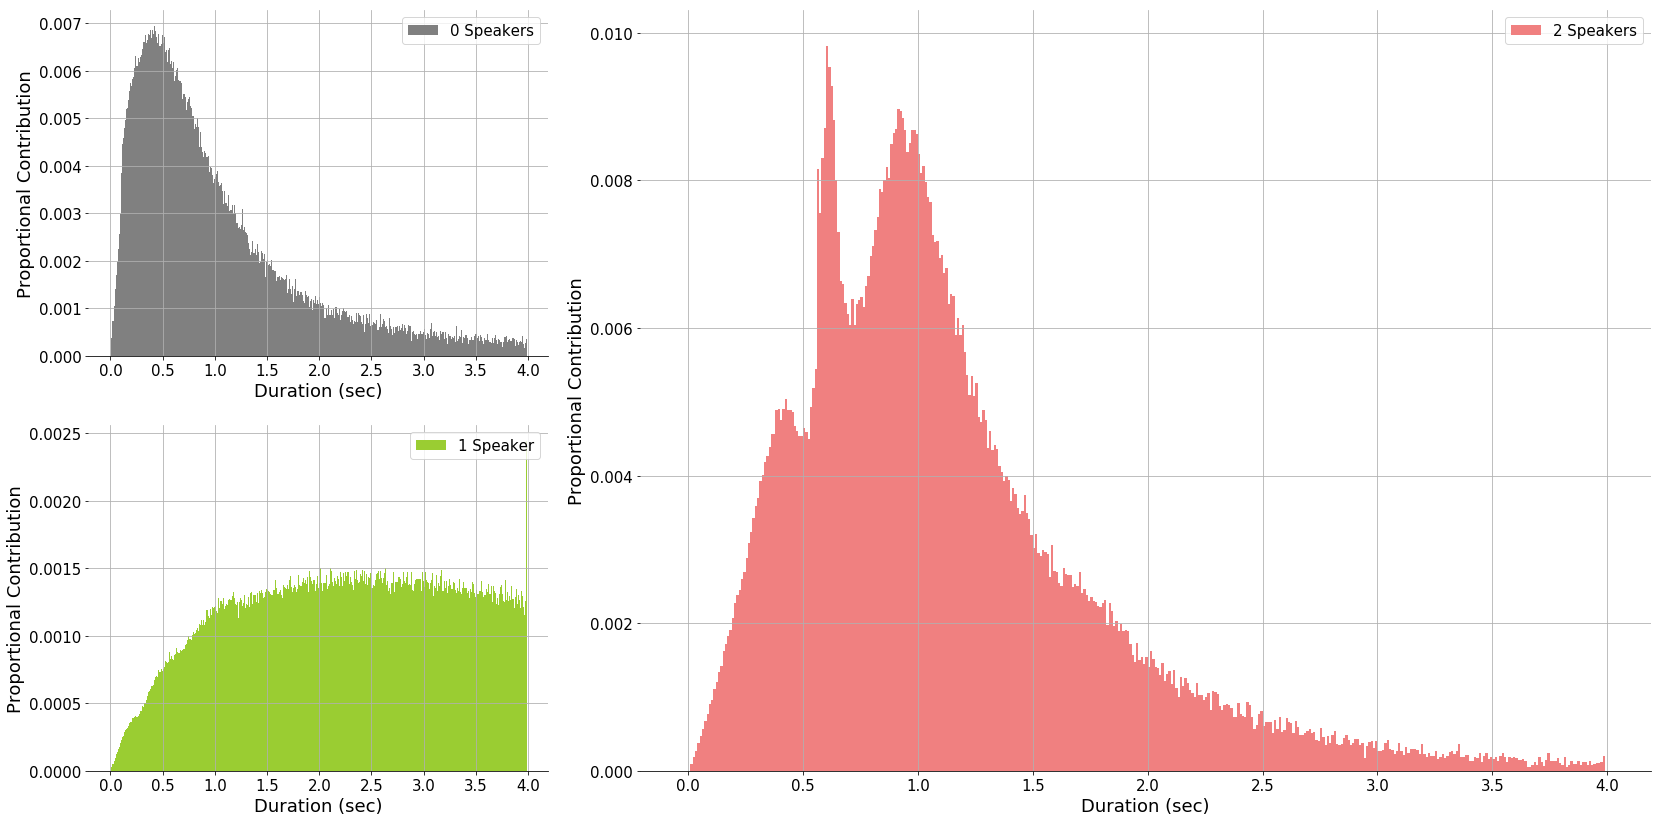

In [189]:
plot_segs(trn_actspksegs)
plot_segs(trn_actspksegs, weighted=True)

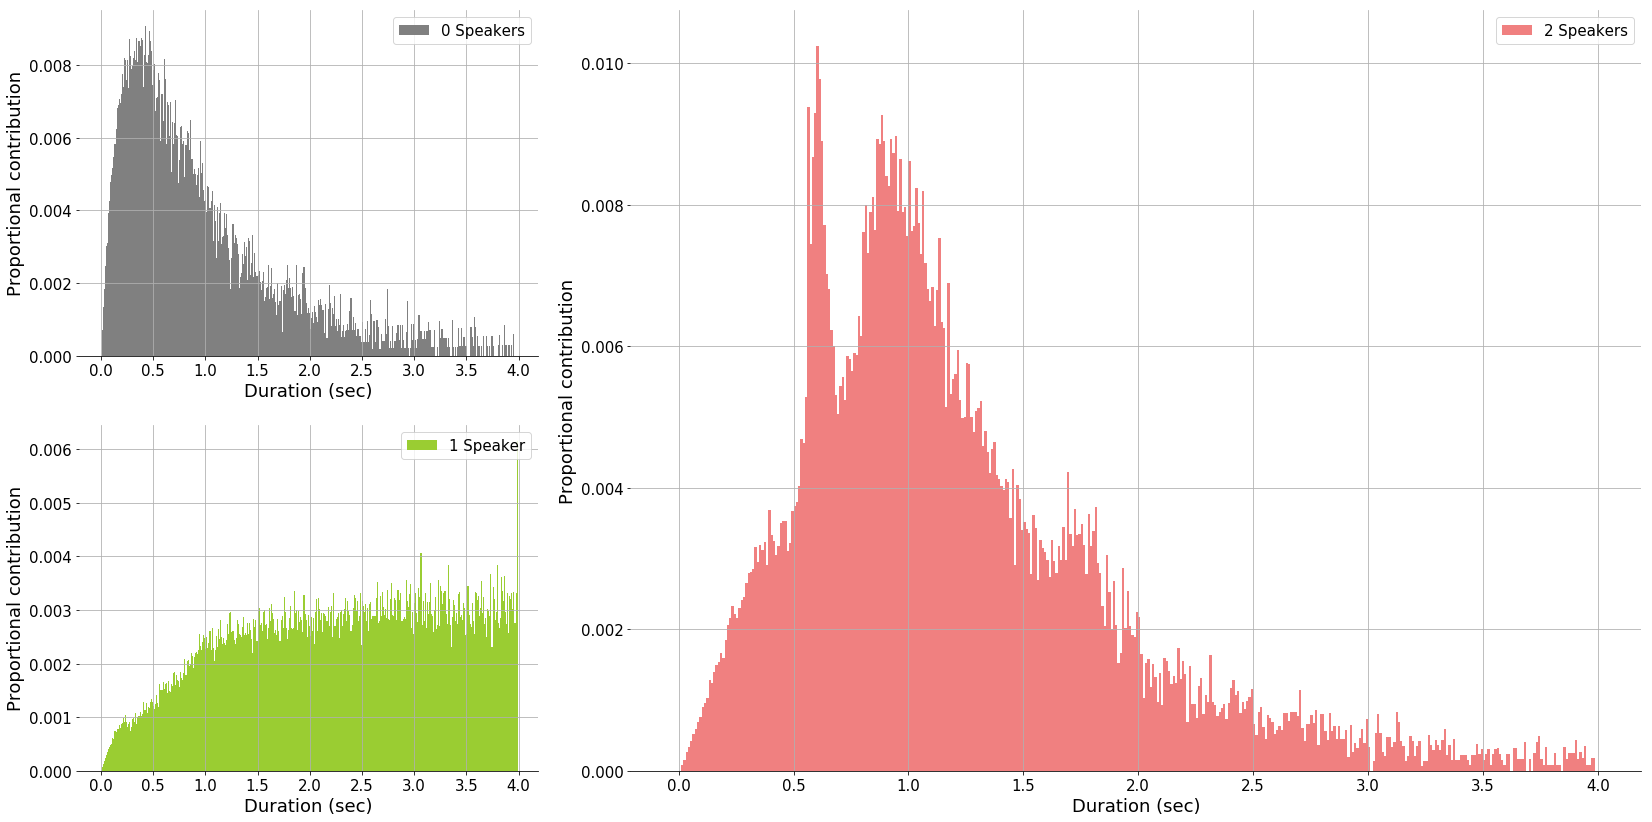

In [201]:
# plot_segs(utst_actspksegs)
plot_segs(utst_actspksegs, weighted=True)

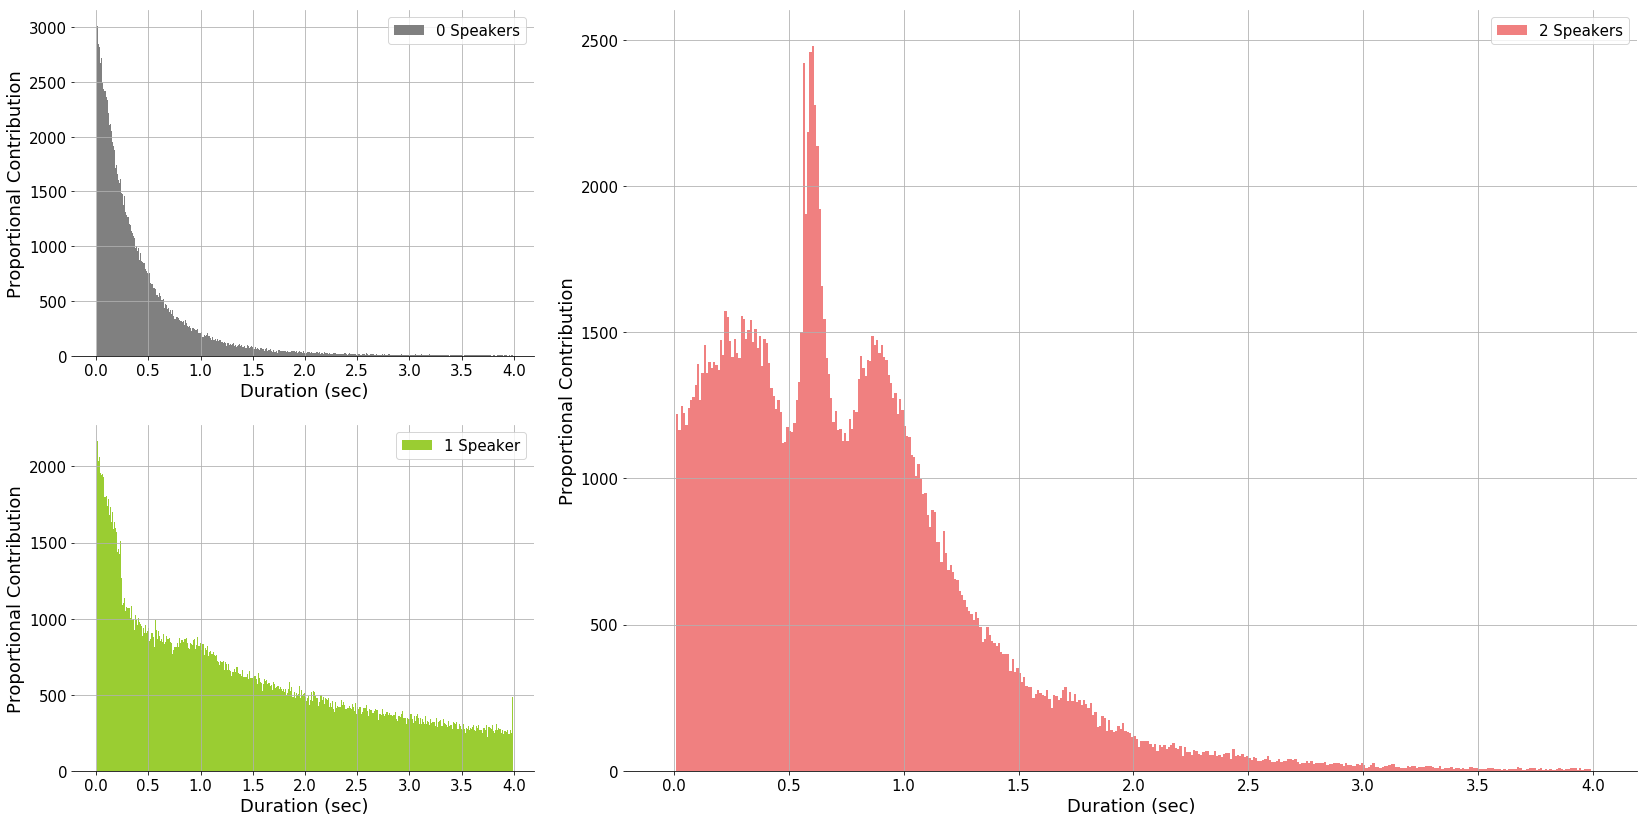

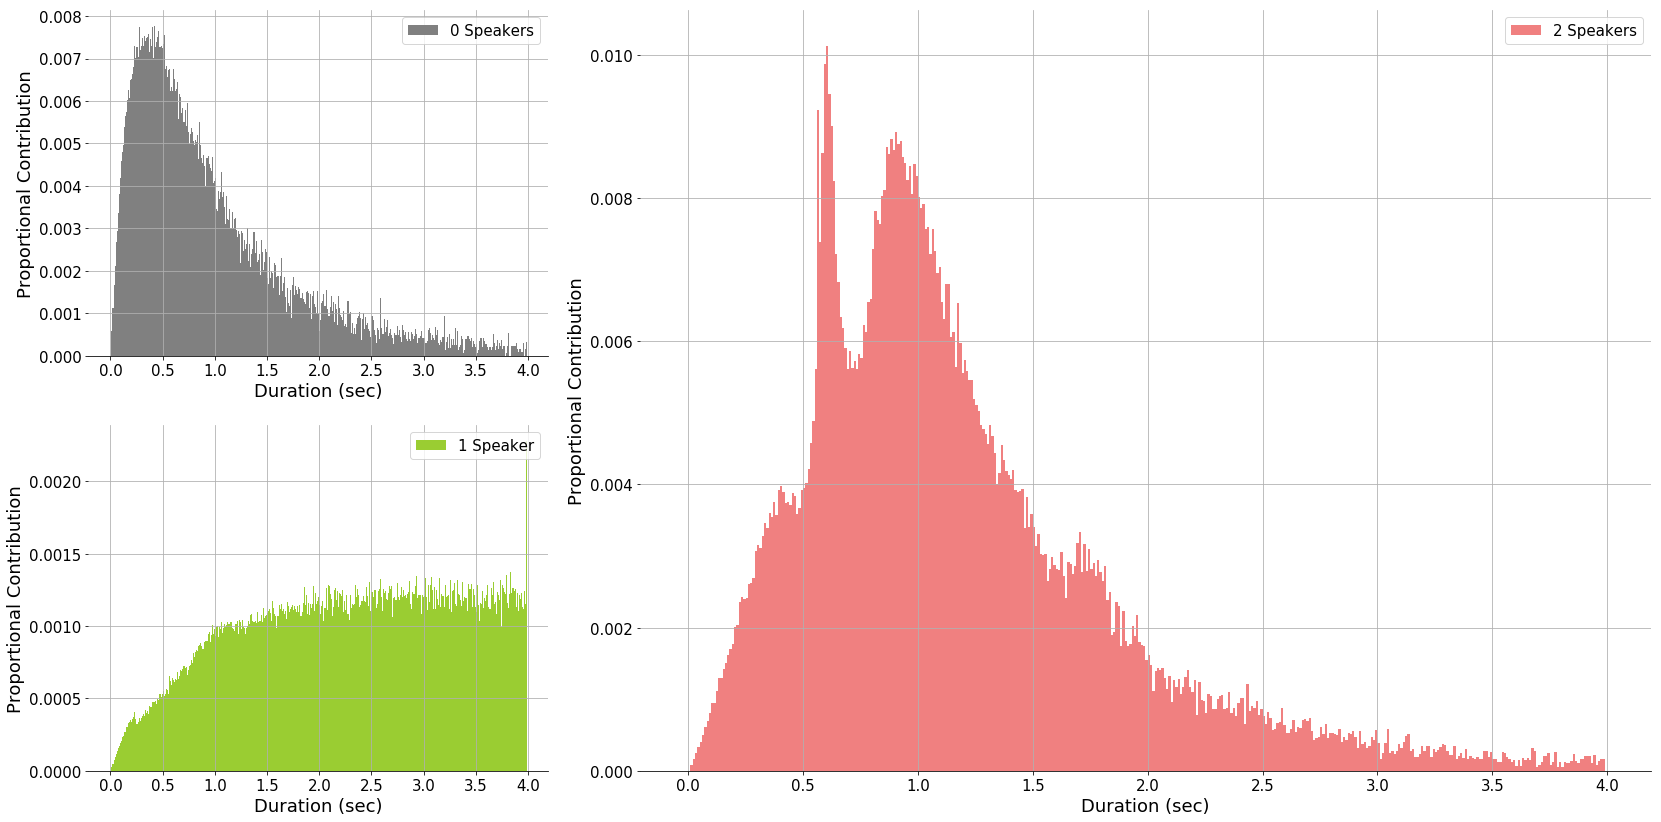

In [188]:
plot_segs(tst_actspksegs)
plot_segs(tst_actspksegs, weighted=True)